# Module 3 Project

Name: Bonnie Ma

Methodology Used: Independent T-Test, Welch's T-Test, Mann Whitney U Test, ANOVA, Central Limit Theorem


Process:
    - Explore the data
    - Develop hypothesis
    - Hypothese test
    - Interpret the results

### Import the librabries 

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm


%matplotlib inline


In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
cur.execute(
"""
SELECT name from sqlite_master
WHERE type="table";
""")

In [4]:
cur.fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

### Define Functions

In [5]:
def sql_with_cols(query,cursor=cur):
  
  result = cursor.execute(query).fetchall()
  cols = tuple([description[0] for description in cur.description])
  
  full_result = (cols, result[:])
  return full_result

def df_sql(query, cursor=cur):
    cols, result_data = sql_with_cols(query, cursor)
    return pd.DataFrame(data=result_data, columns=cols)

In [6]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [148]:
#Two sample T-Test
def two_sample_ttest(a, b, alpha=0.05):
    t, pvalue = stats.ttest_ind(a,b)
    print("P-value is " + str(pvalue))
    if pvalue >= alpha:
        return "Fail to reject the null."
    else:
        return "Reject the null hypothesis."

In [8]:
#Welch's T Test for Samples with different variances
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """
    
    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    t = np.abs(numerator/denominator)
    
    return t

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    df = numerator/denominator
    
    return round(df, 0)
   
     #Return the degrees of freedom

def welch_t_p_value(a, b, two_sided=False):
    
    t = welch_t(a,b)
    df = welch_df(a,b)
    
    p = 1 - stats.t.cdf(t, df)
    
    if two_sided:
        return 2*p
    else:
        return p
    

### Test for Normality

In [99]:
from scipy import stats


In [129]:
def normality_test(data, alpha=0.05):
    
    d, pvalue = stats.kstest(data, 'norm')
    
    if pvalue >= alpha:
        print("Fail to reject the null. The sample is normally distributed!")
    else:
        print("Reject the null. The sample is not normally distributed at the significance level")
        
    

### Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### 1.1 Hypothesis Statement 

$H_0$: Discount amount does **not** have a significant effect on the quantity of a product in an order<br>

$H_a$: Discount amount does have a significant effect on the quantity of a product in an order<br>

Significant level = 95%, alpha = 0.05

### 1.2 Data Exploration

In [9]:
discount = df_sql(
"""
SELECT * FROM OrderDetail

""")

Different levels of discount can be categoried into 5 levels based on frequency: 0%, 5%, 10%, 15%, 20%, 25%0%.
First we examine no discount at all with at least some level of discount; Secondly, we can run Anova tests on different levels and understand which level has the most impact.

In [10]:
discount.groupby("Discount")['Quantity'].count()

Discount
0.00    1317
0.01       1
0.02       2
0.03       3
0.04       1
0.05     185
0.06       1
0.10     173
0.15     157
0.20     161
0.25     154
Name: Quantity, dtype: int64

In [11]:
df = df_sql("""
SELECT OrderId, Sum(Quantity) as quantity, Avg(Discount) as avg_dis FROM OrderDetail

GROUP BY OrderId;

""")
df.head()

,OrderId,quantity,avg_dis
0,10248,27,0.000000
1,10249,49,0.000000
2,10250,60,0.100000
3,10251,41,0.033333
4,10252,105,0.033333


In [12]:
#A: NO DISCOUNT
#B: HAS DISCOUNT
df_nodiscount = df[df['avg_dis']==0]

df_discount= df[df['avg_dis']>0]

In [13]:
a=df_nodiscount['quantity']
a.mean()

52.44

In [14]:
b=df_discount['quantity']
b.mean()

72.94473684210526

In [15]:
def visualization(control, experimental):
    plt.figure(figsize=(10,6))
    sns.distplot(experimental, bins=50,  label='Avg Quantity w/ Discount', color='green')
    sns.distplot(control, bins=50,  label='Avg Quantity w/o Discount', color='blue')

    plt.axvline(x=control.mean(), color='k', linestyle='--')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--')

    plt.title('Discount vs Non-Discount', fontsize=14)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


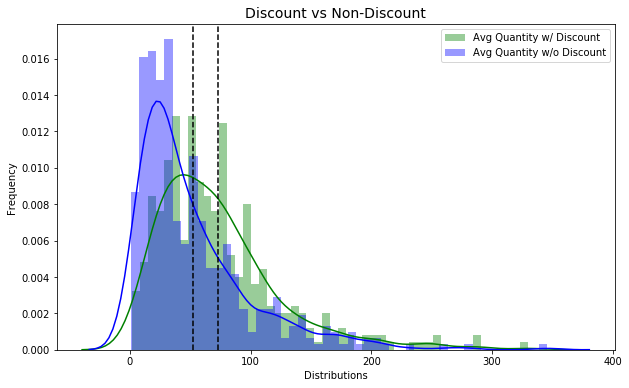

In [16]:
visualization(a, b)

Discount and Non-Discount distributions do not seem to be normally distributed, however, since the sample size is large enough (>30), we can still use T-Test on sample means based on Central Limit Theorem. 

But we still need to test the equality of variance to decide if 2 sample T-Test or Welch's T-Test should be used. 

### 1.3 Hypothesis Test

### Test of Equal Variance

Perform Levene test for equal variances.

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

In [17]:
stats.levene(a, b, center='mean')

LeveneResult(statistic=1.0369358925445291, pvalue=0.30883261672605483)

The Pvalue is 0.3088 > alpha(0.05), so we can not reject the null hypothesis that both samples are from populations with equal variance. Therefore, we can use two sample t test in this case.

### 2 Sample Independent T-Test

In [18]:
stats.ttest_ind(a, b, equal_var=True)

Ttest_indResult(statistic=-5.91731561103876, pvalue=4.7876655924928625e-09)

#### Non Parametric KS Test

In [19]:
#compare the distributions
stats.ks_2samp(a,b)

Ks_2sampResult(statistic=0.26900584795321636, pvalue=1.3184694069188487e-13)

#### Mann-Whitney Test

In [20]:
#Non Parametric equivalent of t tests
stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=59105.0, pvalue=8.524065415288705e-15)

In [21]:
#Confidence level of 95%
alpha = 0.05

#### Conclusion: Since pvalue is smaller than alpha, we reject the null. There is significant effect on product quantity when discount exists. 

#### Effect Size

In [22]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [23]:
abs(Cohen_d(a,b))

0.4122521666326047

#### Cohen's D shows the difference is small to medium

### Next examine whether impact on quantity volume varies on discount levels

$H_0$: There is **no** significant difference in impact on quantity between discount levels <br>

$H_a$: There is significant difference in impact on quantity between at least one discount levels<br>

Significant level = 95%, alpha = 0.05


In [24]:
discount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


Data Exploration

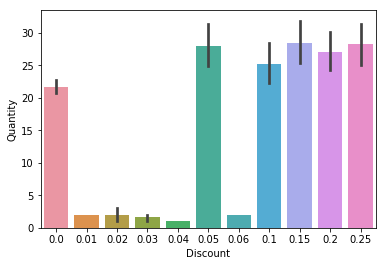

In [25]:
ax = sns.barplot(x="Discount", y="Quantity", data=discount)

Only keep 5%, 10%, 15%, 20%, 25%

**Data Transformation**

In [26]:
discount1 = discount.pivot(columns='Discount',values='Quantity') 

In [27]:
discount1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 11 columns):
0.0     1317 non-null float64
0.01    1 non-null float64
0.02    2 non-null float64
0.03    3 non-null float64
0.04    1 non-null float64
0.05    185 non-null float64
0.06    1 non-null float64
0.1     173 non-null float64
0.15    157 non-null float64
0.2     161 non-null float64
0.25    154 non-null float64
dtypes: float64(11)
memory usage: 202.0 KB


In [28]:
discount2 = discount1.drop(columns={0.01,0.02,0.03,0.04,0.06})

In [29]:
discount2 = discount1.rename(columns={0.0:"A",0.05:"B",0.1:"C",0.15:"D",0.2:"E",0.25:"F"})

In [30]:
discount2.head()

Discount,A,0.01,0.02,0.03,0.04,B,0.06,C,D,E,F
0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
A = discount2['A'].dropna()
B = discount2['B'].dropna()
C = discount2['C'].dropna()
D = discount2['D'].dropna()
E = discount2['E'].dropna()
F = discount2['F'].dropna()

### Test for equality of variances for 5 discount groups

In [32]:
stats.levene(B,C,D,E,F)

LeveneResult(statistic=0.2092544330590371, pvalue=0.9333364288844539)

Since Pvalue > alpha (0.05), we can not reject the null which believes samples are from population with equal variance. We can use ANOVA test.

#### Use stats.f_oneway 

In [33]:
f_stat, p_value = stats.f_oneway(B,C,D,E,F)
print('F-stat:',f_stat)
print('p-value:',p_value)

F-stat: 0.6741032559876151
p-value: 0.610041445360832


#### Use multiple linear regression

In [34]:
df = df_sql(
"""
SELECT * FROM OrderDetail
WHERE Discount IN (0.05, 0.1, 0.15, 0.2, 0.25);

""")

In [35]:
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10251/22,10251,22,16.8,6,0.05
3,10251/57,10251,57,15.6,15,0.05
4,10252/20,10252,20,64.8,40,0.05


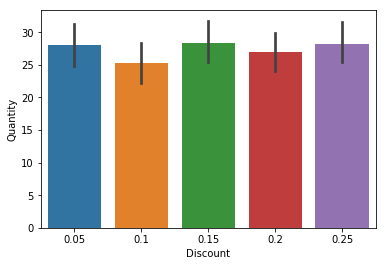

In [36]:
ax = sns.barplot(x='Discount', y='Quantity', data = df)

In [37]:
df['Discount'] = df['Discount'].astype('category')

In [38]:
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10251/22,10251,22,16.8,6,0.05
3,10251/57,10251,57,15.6,15,0.05
4,10252/20,10252,20,64.8,40,0.05


In [39]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [40]:
results = ols('Quantity ~ Discount', data=df).fit()

table = sm.stats.anova_lm(results, typ=1)

print(table)

             df         sum_sq     mean_sq         F    PR(>F)
Discount    4.0    1159.517551  289.879388  0.674103  0.610041
Residual  825.0  354768.342690  430.022234       NaN       NaN


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 0.05   0.1   -2.7738  -8.7696 3.222  False 
 0.05   0.15   0.3714  -5.7803 6.523  False 
 0.05   0.2    -0.986  -7.0962 5.1242 False 
 0.05   0.25   0.2294  -5.9546 6.4134 False 
 0.1    0.15   3.1452  -3.1037 9.394  False 
 0.1    0.2    1.7879  -4.4202 7.9959 False 
 0.1    0.25   3.0033  -3.2774 9.2839 False 
 0.15   0.2   -1.3573   -7.716 5.0014 False 
 0.15   0.25  -0.1419  -6.5715 6.2877 False 
 0.2    0.25   1.2154  -5.1745 7.6054 False 
--------------------------------------------


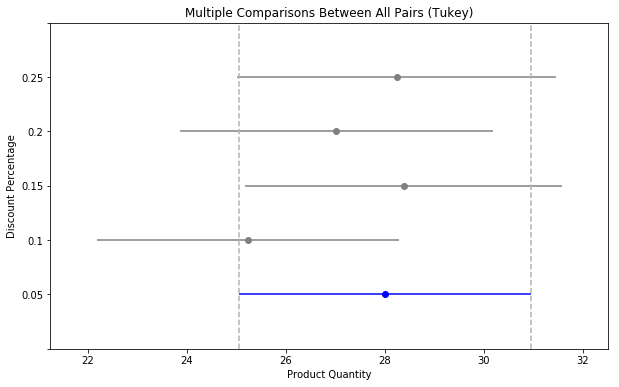

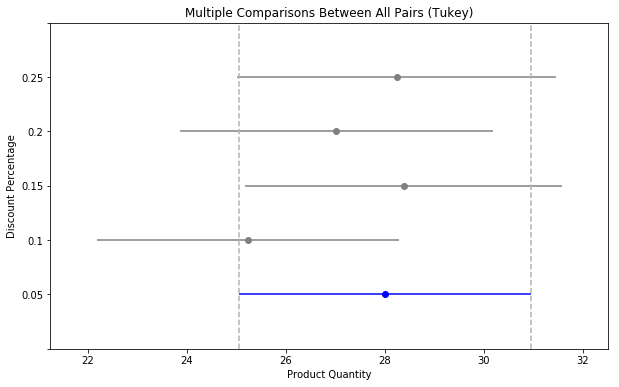

In [41]:
#Do Tukey's after Anova, Tukey makes your alpha even smaller.
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

com = MultiComparison(df['Quantity'],df['Discount'])
tukey = com.tukeyhsd()
print(tukey.summary())
tukey.plot_simultaneous(comparison_name = 0.05, figsize=(10,6), ylabel='Discount Percentage', xlabel='Product Quantity')

### 1.4 Result Intepretation

- There is significant difference between Discount vs Non Discount
- There is no signicant difference among different discount levels

## Question 2: Region Performance - Does each region generate same average order revenue?


### 2.1 Hypothesis Development

$H_0$: The average revenue per order is **NOT** different across regions<br>

$H_a$: The average revenue per order **IS** different across regions<br>

Significant level = 95%, alpha = 0.05

### 2.2 Data Exploration

Join Order and OrderDetail to get total revenue from all regions

In [42]:
customer = df_sql(
"""
SELECT * FROM Customer

       """)

In [43]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
Id              91 non-null object
CompanyName     91 non-null object
ContactName     91 non-null object
ContactTitle    91 non-null object
Address         91 non-null object
City            91 non-null object
Region          91 non-null object
PostalCode      90 non-null object
Country         91 non-null object
Phone           91 non-null object
Fax             69 non-null object
dtypes: object(11)
memory usage: 7.9+ KB


In [44]:
df = df_sql(
"""
SELECT A.OrderId, A.CustomerId, A.Region, SUM(A.Revenue) as OrderRevenue
FROM

(SELECT O.Id AS OrderId,O.CustomerID, C.Region, D.UnitPrice, D.Quantity, D.Discount, (D.Quantity * D.UnitPrice * (1-D.Discount)) AS Revenue  FROM Customer C
JOIN 'Order' O
ON C.ID = O.CustomerId
JOIN OrderDetail D
ON D.OrderId = O.Id) A

GROUP BY A.OrderId

       """)

In [45]:
df.head()

,OrderId,CustomerID,Region,OrderRevenue
0,10248,VINET,Western Europe,440.00
1,10249,TOMSP,Western Europe,1863.40
2,10250,HANAR,South America,1552.60
3,10251,VICTE,Western Europe,654.06
4,10252,SUPRD,Western Europe,3597.90


In [46]:
df.groupby('Region')['OrderId'].count()

Region
British Isles       75
Central America     21
Eastern Europe       7
North America      152
Northern Europe     55
Scandinavia         28
South America      127
Southern Europe     64
Western Europe     272
Name: OrderId, dtype: int64

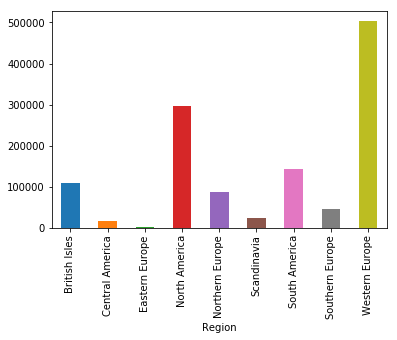

In [47]:
df.groupby('Region')['OrderRevenue'].sum().plot.bar()

In [48]:
df.groupby('Region')['OrderRevenue'].agg(['min','max','sum','mean'])

,min,max,sum,mean
Region,,,,
British Isles,45.00,10835.24,108951.2150,1452.682867
Central America,88.80,4150.05,16558.1000,788.480952
Eastern Europe,160.00,808.00,3531.9500,504.564286
North America,36.00,12615.05,295780.9005,1945.926977
Northern Europe,48.75,11188.40,87156.1625,1584.657500
Scandinavia,120.00,2684.40,24545.2025,876.614375
South America,12.50,15810.00,142677.8080,1123.447307
Southern Europe,18.40,3026.85,45225.7175,706.651836
Western Europe,28.00,16387.50,503548.4085,1851.280914


Text(0.5, 0, 'Revenue ($)')

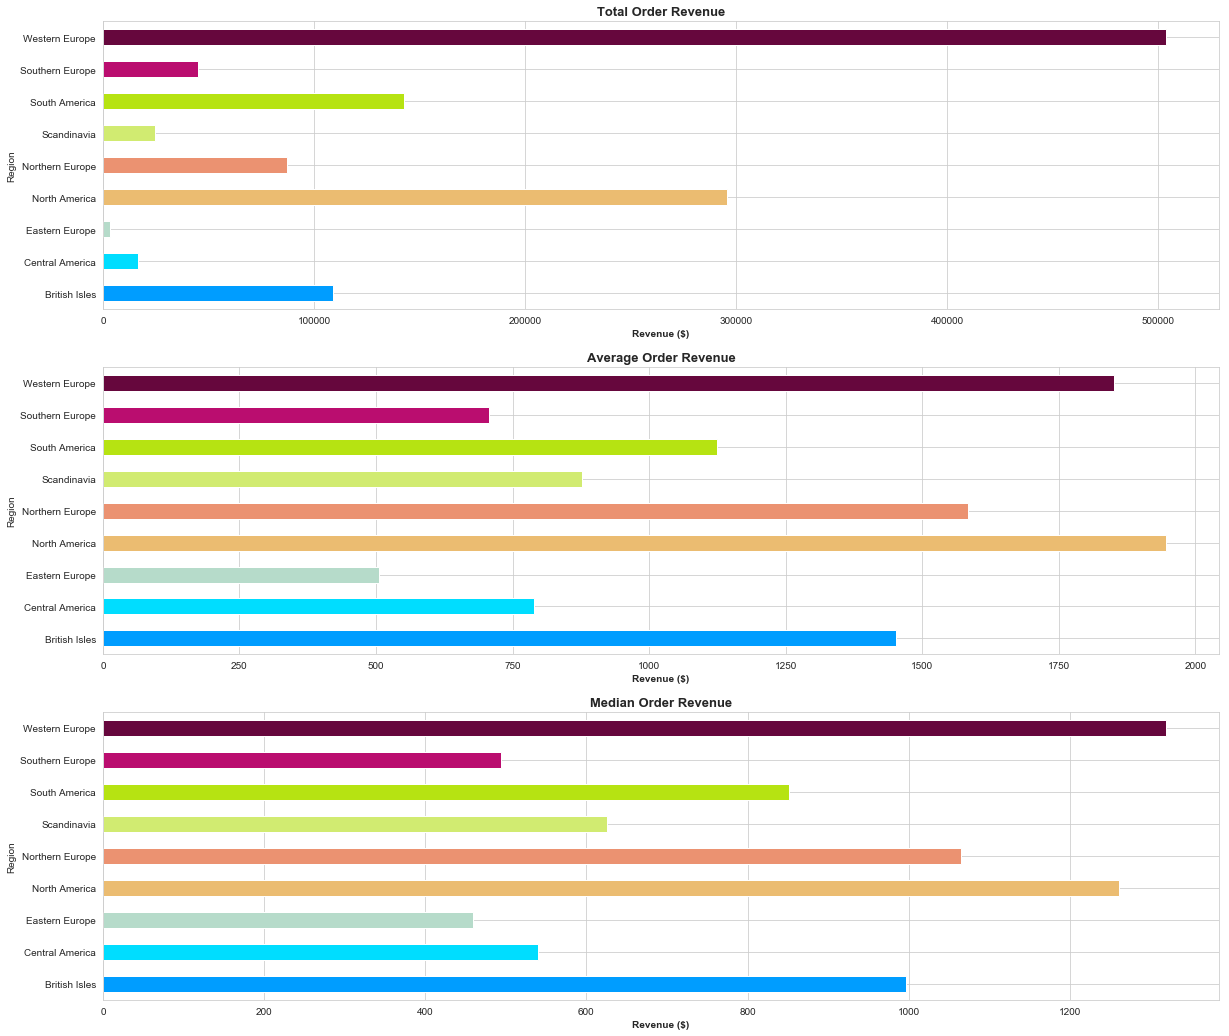

In [49]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(3,1, figsize=(20,18))
color1=['#009dff', '#00ddff', '#b6dbca','#ebbc71','#eb9271', '#d1eb71', '#b6e312', '#ba0d6f', '#66073d']

df.groupby('Region')['OrderRevenue'].sum().plot(kind='barh', ax = axes[0], color=color1)
df.groupby('Region')['OrderRevenue'].mean().plot(kind='barh', ax = axes[1], color=color1)
df.groupby('Region')['OrderRevenue'].median().plot(kind='barh', ax = axes[2], color=color1)

# Subplot 1 Labels:
axes[0].set_title('Total Order Revenue', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Revenue ($)', fontweight='semibold')

#Subplot 2 Labels:
axes[1].set_title('Average Order Revenue', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Revenue ($)', fontweight='semibold')

#Subplot 2 Labels:
axes[2].set_title('Median Order Revenue', fontweight='bold', fontsize=13)
axes[2].set_xlabel('Revenue ($)', fontweight='semibold')


9 Regions have quite different total revenue at a glance with Western Europe being the top driver, following by North America. However, some regions have close average revenue per customer such as Western Europe and North America. Looking at avg revenue per customer helps the company evalute types of business in the region: Small - Meidum Business vs Enterprise

In [50]:
#Number of Customers by Region 
df.groupby('Region')['CustomerID'].count()

Region
British Isles       75
Central America     21
Eastern Europe       7
North America      152
Northern Europe     55
Scandinavia         28
South America      127
Southern Europe     64
Western Europe     272
Name: CustomerID, dtype: int64

**Two ways of looking at regions**
- Divide 9 regions to 5 bigger regions: Western & Eastern Europe; Northern & Southern Europe; British Isles & Scandinavia; North America; Central & South America
- Divide 9 regions to 2 parts: Europe, Americas

In [51]:
df.head()

,OrderId,CustomerID,Region,OrderRevenue
0,10248,VINET,Western Europe,440.00
1,10249,TOMSP,Western Europe,1863.40
2,10250,HANAR,South America,1552.60
3,10251,VICTE,Western Europe,654.06
4,10252,SUPRD,Western Europe,3597.90


In [52]:
df.loc[(df.Region == 'Western Europe') | (df.Region == 'Eastern Europe'), 'NewRegion'] = 'W & E Europe'
df.loc[(df.Region == 'Northern Europe') | (df.Region == 'Southern Europe'), 'NewRegion'] = 'N & S Europe'
df.loc[(df.Region == 'British Isles') | (df.Region == 'Scandinavia'), 'NewRegion'] = 'British Isles & Scandinavia'
df.loc[df.Region == 'North America' , 'NewRegion'] = 'North America'
df.loc[(df.Region == 'Central America') | (df.Region == 'South America'), 'NewRegion'] = 'C & S America'

In [53]:
df.loc[(df.NewRegion == 'W & E Europe') | (df.NewRegion == 'N & S Europe') | (df.NewRegion == 'British Isles & Scandinavia'), 'Area'] = 'Europe'
df.loc[(df.NewRegion == 'North America') | (df.NewRegion == 'C & S America'), 'Area'] = 'Americas'

In [54]:
df.groupby('Region')['NewRegion'].count()

Region
British Isles       75
Central America     21
Eastern Europe       7
North America      152
Northern Europe     55
Scandinavia         28
South America      127
Southern Europe     64
Western Europe     272
Name: NewRegion, dtype: int64

In [55]:
df.groupby('NewRegion')['OrderRevenue'].agg(['min','max','sum','mean','count'])

,min,max,sum,mean,count
NewRegion,,,,,
British Isles & Scandinavia,45.0,10835.24,133496.4175,1296.081723,103
C & S America,12.5,15810.00,159235.9080,1075.918297,148
N & S Europe,18.4,11188.40,132381.8800,1112.452773,119
North America,36.0,12615.05,295780.9005,1945.926977,152
W & E Europe,28.0,16387.50,507080.3585,1817.492324,279


In [56]:
sub_df = df[['NewRegion','OrderRevenue']]

### 2.3 Hypothesis Test

In [57]:
#Construct Test datasets: W&E Europe - E1, N&S Europe - E2, British & Scandinavia - E3, North America - A1, C&S America - A2
E1 = sub_df[sub_df['NewRegion']=='W & E Europe']['OrderRevenue']
E2 = sub_df[sub_df['NewRegion']=='N & S Europe']['OrderRevenue']
E3 = sub_df[sub_df['NewRegion']=='British Isles & Scandinavia']['OrderRevenue']
A1 = sub_df[sub_df['NewRegion']=='North America']['OrderRevenue']
A2 = sub_df[sub_df['NewRegion']=='C & S America']['OrderRevenue']

Text(0.5, 1.0, 'Distribution of Revenue by Region')

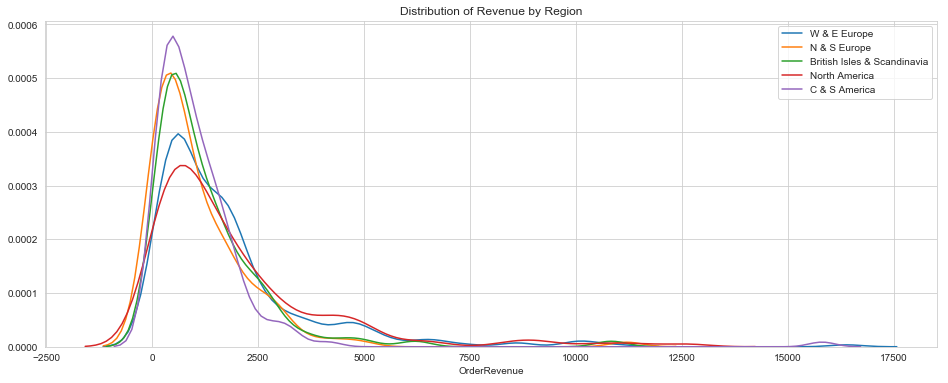

In [60]:
#Plot the distributions of 5 regions

plt.figure(figsize=(16,6))
ax = sns.distplot(E1, hist=False, label='W & E Europe')
ax = sns.distplot(E2, hist=False, label='N & S Europe')
ax = sns.distplot(E3, hist=False, label='British Isles & Scandinavia')
ax = sns.distplot(A1, hist=False, label='North America')
ax = sns.distplot(A2, hist=False, label='C & S America')
plt.title('Distribution of Revenue by Region')

Not normally distributed. However, the sample size is large enough. 

### Test of Equal Variance

Perform Levene test for equal variances.

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

In [61]:
stats.levene(E1,E2,E3,A1,A2, center='mean')

LeveneResult(statistic=8.57499006538664, pvalue=8.901192485232916e-07)

The Pvalue is < alpha(0.05), so we can reject the null hypothesis that both samples are from populations with equal variance. Therefore, we have to use non-parametric Krusal-Wallis Test 

### Krusal-Wallis Test

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post-hoc comparisons between groups are required to determine which groups are different.

In [62]:
stats.kruskal(E1, E2, E3, A1, A2)

KruskalResult(statistic=36.797653501198766, pvalue=1.9827434923176663e-07)

P-value is < alpha (0.05), therefore we can reject the null. There is significant difference in the average revenue in 5 regions. 

group1,group2,meandiff,lower,upper,reject
British Isles & Scandinavia,C & S America,-220.1634,-858.4592,418.1323,False
British Isles & Scandinavia,N & S Europe,-183.629,-853.0802,485.8223,False
British Isles & Scandinavia,North America,649.8453,15.0053,1284.6852,True
British Isles & Scandinavia,W & E Europe,521.4106,-52.1054,1094.9266,False
C & S America,N & S Europe,36.5345,-575.937,649.0059,False
C & S America,North America,870.0087,295.5715,1444.4459,True
C & S America,W & E Europe,741.574,235.7313,1247.4168,True
N & S Europe,North America,833.4742,224.6051,1442.3433,True
N & S Europe,W & E Europe,705.0396,160.4109,1249.6682,True
North America,W & E Europe,-128.4347,-629.9097,373.0404,False


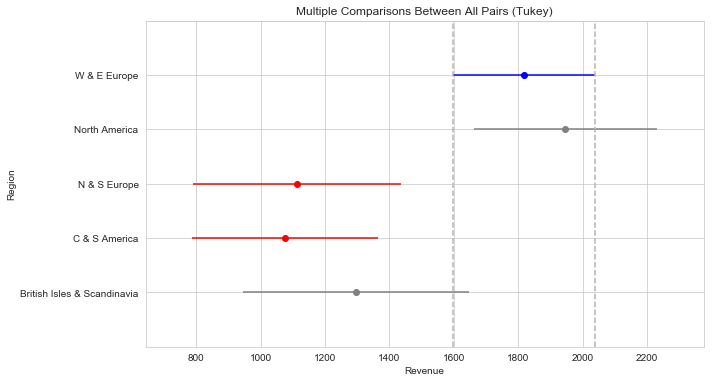

In [63]:
#Tukey's HSD post-hoc comparisons
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

com = MultiComparison(df['OrderRevenue'], df['NewRegion'])
tukey = com.tukeyhsd()
tukey.plot_simultaneous(comparison_name='W & E Europe', xlabel='Revenue', ylabel='Region')
tukey.summary()


plot_intervals will color code all groups that are significantly different from the comparison_name red, and will color code insignificant groups gray. Otherwise, all intervals will just be plotted in black.

Conclusion: The average order revenue of 5 regions are not all the same. 5 regions can be classified to three groups and within groups, there are more similarity. North America and Western & Eastern Europe are in Group 1;Northern & Southern Europe, Central & Southern America are in Group 2,  British Isles & Scandinavia is in Group 3. Group 1 generate significantly more revenue than Group 2, while Group 3 is in the middle of Group 1 and 2. 

## Question 3: Category Performance - Does discount impact category performance?

- If discount has an effect on quantity for specific categories?

### 3.1 Hypothesis Statement

$H_0$: Discount does not have impact on the quantity of any category<br>
$H_a$: Discount does have impact on the quantity of one or more categories<br>

Signigicantly level: 95%, alpha = 0.05

### 3.2 Data Exploration

In [75]:
product = df_sql(
"""
SELECT * FROM Product

""")

In [76]:
product.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [77]:
#Join Product and Category

category = df_sql("""
SELECT * FROM OrderDetail
""")
category.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


Join OrderDetail, Product, Category

In [87]:
category = df_sql("""


SELECT O.OrderId, P.Id AS ProductId, C.CategoryName, O.UnitPrice, O.Quantity, O.Discount FROM OrderDetail O
JOIN
Product P
ON O.ProductId = P.Id
JOIN Category C
ON P.CategoryId = C.Id

"""
)

In [88]:
category.head()

,OrderId,ProductId,CategoryName,UnitPrice,Quantity,Discount
0,10248,11,Dairy Products,14.0,12,0.0
1,10248,42,Grains/Cereals,9.8,10,0.0
2,10248,72,Dairy Products,34.8,5,0.0
3,10249,14,Produce,18.6,9,0.0
4,10249,51,Produce,42.4,40,0.0


In [89]:
#Calculate line revenue
category['revenue']=category['UnitPrice']*category['Quantity']*(1-category['Discount'])

In [90]:
#Assign Identifier to Discount vs No-Discount

category.loc[(category.Discount != 0), 'Disc_label'] = "Discount"
category.loc[(category.Discount == 0), 'Disc_label'] = "No Discount"


In [91]:
category.head()

,OrderId,ProductId,CategoryName,UnitPrice,Quantity,Discount,revenue,Disc_label
0,10248,11,Dairy Products,14.0,12,0.0,168.0,No Discount
1,10248,42,Grains/Cereals,9.8,10,0.0,98.0,No Discount
2,10248,72,Dairy Products,34.8,5,0.0,174.0,No Discount
3,10249,14,Produce,18.6,9,0.0,167.4,No Discount
4,10249,51,Produce,42.4,40,0.0,1696.0,No Discount


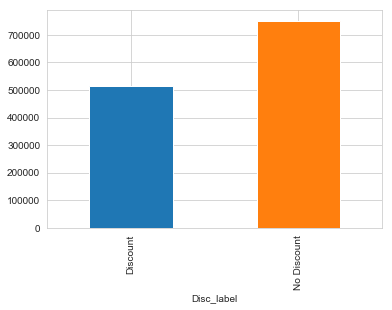

In [92]:
#Plot Total Revenue by Category. 
category.groupby('Disc_label')['revenue'].sum().plot.bar()

Text(0.5, 1.0, 'Category Revenue Discount vs Non-Discount')

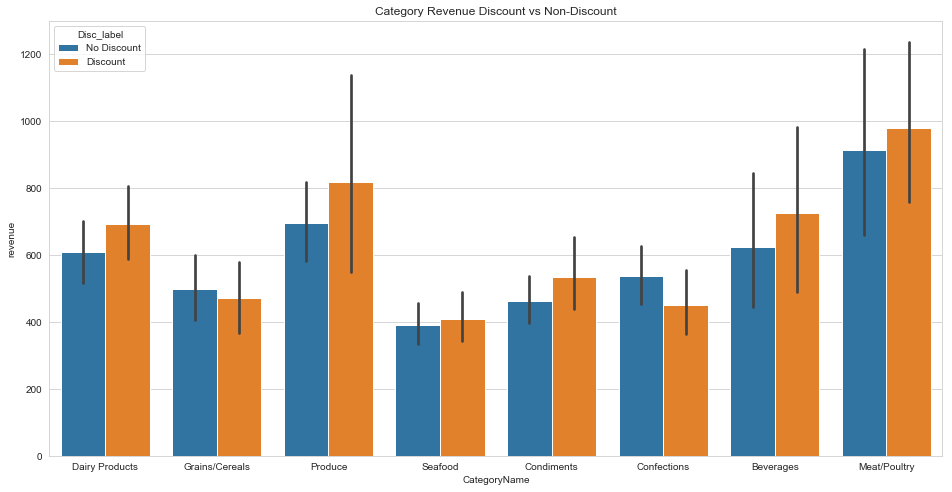

In [94]:
plt.figure(figsize=(16,8))
ax = sns.barplot(x='CategoryName', y="revenue", hue="Disc_label", data=category)
ax.set_title("Category Revenue Discount vs Non-Discount")

**Essentially we need 8 T-Tests 

Check sample size of each category

In [97]:
category.pivot_table(values='revenue', index='CategoryName', columns='Disc_label', aggfunc="count")

Disc_label,Discount,No Discount
CategoryName,,
Beverages,158,246
Condiments,85,131
Confections,134,200
Dairy Products,142,224
Grains/Cereals,63,133
Meat/Poultry,76,97
Produce,45,91
Seafood,135,195


All sample groups have sample size of > 25. 

Construct test datasets

In [124]:
A = category['Disc_label']=='Discount'
B = category['Disc_label']=='No Discount'

Beverage = category['CategoryName'] == 'Beverages'
Condiments = category['CategoryName'] == 'Condiments'
Confections = category['CategoryName'] == 'Confections'
Dairy = category['CategoryName'] == 'Dairy Products'
Grains = category['CategoryName'] == 'Grains/Cereals'
Meat = category['CategoryName'] == 'Meat/Poultry'
Produce = category['CategoryName'] == 'Produce'
Seafood = category['CategoryName'] == 'Seafood'


In [125]:
beverage_d = category[A][Beverage]['revenue']
beverage_nd = category[B][Beverage]['revenue']

condiment_d = category[A][Condiments]['revenue']
condiment_nd = category[B][Condiments]['revenue']

confection_d = category[A][Confections]['revenue']
confection_nd = category[B][Confections]['revenue']

dairy_d = category[A][Dairy]['revenue']
dairy_nd = category[B][Dairy]['revenue']

grain_d = category[A][Grains]['revenue']
grain_nd = category[B][Grains]['revenue']

meat_d = category[A][Meat]['revenue']
meat_nd = category[B][Meat]['revenue']

produce_d = category[A][Produce]['revenue']
product_nd = category[B][Produce]['revenue']

seafood_d = category[A][Seafood]['revenue']
seafood_nd = category[B][Seafood]['revenue']

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reinde

#### Discount on Beverage Category

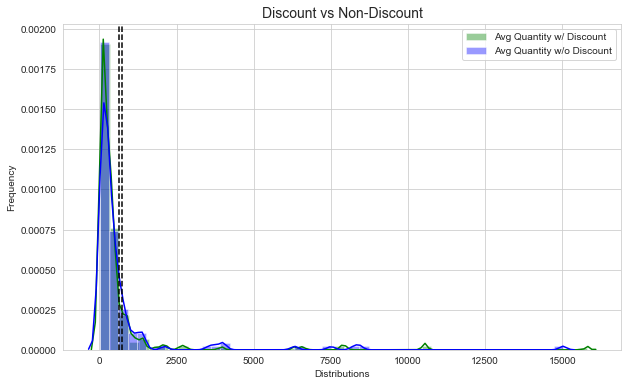

In [131]:
visualization(beverage_d, beverage_nd)

Apparently does not follow normal distribution. Test for equality of variances. 

In [142]:
def variance_test(a,b):
    statistic, pvalue = stats.levene(a,b, center='mean')
    print("P-value is: " + str(pvalue))
    if pvalue >= 0.05:
        return "Fail to reject the null that two samples are from populations that have same variance"
    else:
        return "Reject the null. Two samples are from populations that do not have same variance"

In [149]:
variance_test(beverage_d, beverage_nd)

P-value is: 0.4803122812920245


'Fail to reject the null that two samples are from populations that have same variance'

**Two Sample Independent T-Test**

In [144]:
stats.ttest_ind(beverage_d, beverage_nd)

Ttest_indResult(statistic=0.6071662090933465, pvalue=0.5440833957812259)

In [151]:
two_sample_ttest(beverage_d, beverage_nd)

P-value is 0.5440833957812259


'Fail to reject the null.'

Keep doing it for the other categories... 

In [ ]:
visualization(condiment_d, condiment_nd)

In [123]:
normality_test(beverage_d, 0.05)

0.0


'Reject the null. The sample is not normally distributed at the significance level'

In [ ]:
#How about 

In [71]:
df = df_sql(
"""
SELECT * FROM

(SELECT D.ProductId, D.UnitPrice, D.Quantity, D.Discount, E.ID AS OrderId, E.ShipRegion, E.ShipCity, E.ShipCountry  FROM 'OrderDetail' AS D
LEFT JOIN 'Order'AS E
ON D.OrderId = E.Id) O

LEFT JOIN

(SELECT CategoryId, CategoryName FROM Product
JOIN Category
ON product.CategoryId = Category.Id) P
ON 
O.ProductId = P.Id

""")


OperationalError: no such column: P.Id

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df = df.drop(columns=['Id','Id:1'])

In [ ]:
data=df[['UnitPrice','Quantity','Discount','CategoryName']]

In [ ]:
data['Quantity']=[float(x) for x in data['Quantity']]

In [ ]:
data.info()

In [78]:
regions = df['ShipRegion'].unique()

Text(0.5, 1.0, 'Quantity by Categories in Western Europe')
Text(0.5, 1.0, 'Quantity by Categories in South America')
Text(0.5, 1.0, 'Quantity by Categories in Central America')
Text(0.5, 1.0, 'Quantity by Categories in North America')
Text(0.5, 1.0, 'Quantity by Categories in Northern Europe')
Text(0.5, 1.0, 'Quantity by Categories in Scandinavia')
Text(0.5, 1.0, 'Quantity by Categories in Southern Europe')
Text(0.5, 1.0, 'Quantity by Categories in British Isles')
Text(0.5, 1.0, 'Quantity by Categories in Eastern Europe')


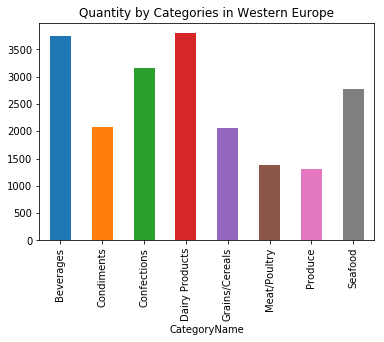

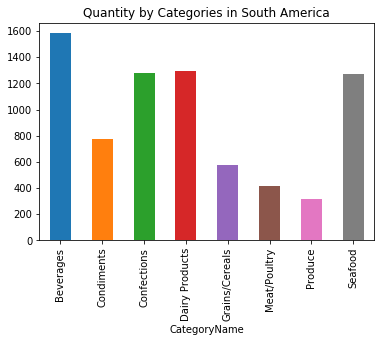

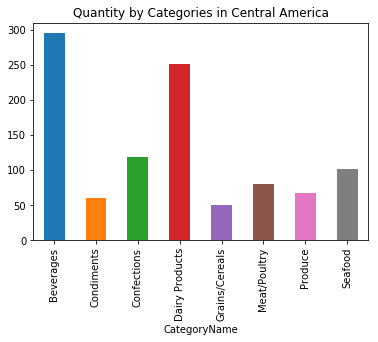

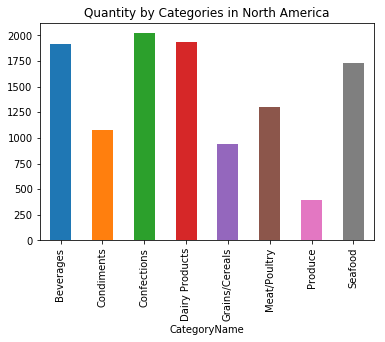

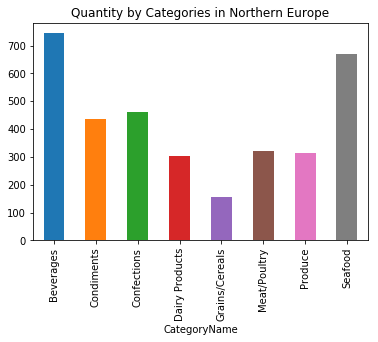

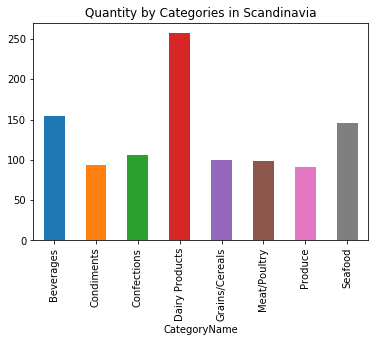

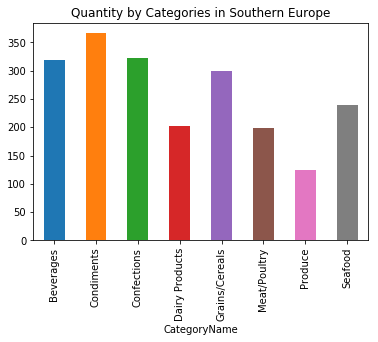

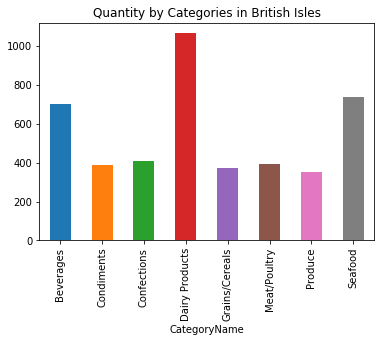

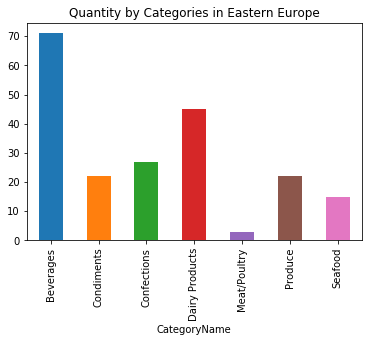

In [68]:
#Explore category within each region
for i in regions:
    
    x = df[df['ShipRegion']==i]
    plt.figure()
    x.groupby('CategoryName')['Quantity'].sum().plot.bar()
    print(plt.title("Quantity by Categories in " + i))

    

In [69]:
West_Europe = df[df['ShipRegion']=='Western Europe']

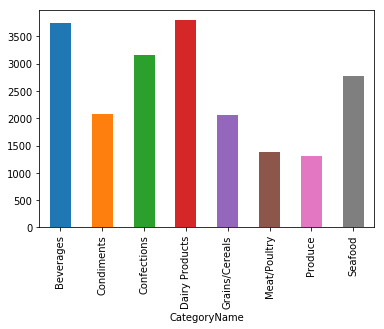

In [70]:
West_Europe.groupby('CategoryName')['Quantity'].sum().plot.bar()

In [47]:
df['ShipRegion'].nunique()

9

In [51]:
df['Region'].nunique()

2

## Does Seasonality impact Sales?
- Does seasonality impact all sales?
- Does seasonality impact all regions?
- Does seasonality impact all categories? If so, what is our stategy? 
